In [1]:
%load_ext autoreload
%autoreload 2
#%reload_ext autoreload
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import math
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
from collections import OrderedDict
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
from sklearn.decomposition import TruncatedSVD
from shutil import copyfile
import scipy


np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

from codes.experimentclasses.AtomicRegression2 import AtomicRegression
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.flasso.Replicate import Replicate
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.TangentBundle import TangentBundle
from codes.geometer.ShapeSpace import ShapeSpace

/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
diffusion_time = 1. #embedding radius
dim = 2 #manifold dimension
dimnoise = 2 #manifold dimension (not in mflasso paper)
cores = 3 

In [3]:
nreps = 5
#new_MN = True
#new_grad = True
savename = 'ethanol_021521'
savefolder = 'ethanol'
loadfolder = 'ethanol'
loadname = 'ethanol_021521'
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

folder = workingdirectory + '/Figures/ethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

In [4]:
natoms = 9
experiment = AtomicRegression(natoms)
experiment.m = m
experiment.dim = dim
experiment.atoms3, experiment.da = experiment.get_atoms_3()

In [5]:
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'
data_xyz_loaded = scipy.io.loadmat(data_wd + '/untracked_data/chemistry_data/ethanol.mat')
angle_indices = np.load(data_wd + '/untracked_data/chemistry_data/ethanolindices022119.npy')
experiment.positions =  data_xyz_loaded['R'][angle_indices]
filename_angles = data_wd + '/untracked_data/chemistry_data/ethanolangles022119.npy'
data = np.arccos(np.reshape(np.load(filename_angles), (50000, experiment.da)))

In [6]:
experiment.M = RiemannianManifold(data, dim)#experiment.load_data(workingdirectory = data_wd)
experiment.svd = TruncatedSVD(n_components=50)
experiment.Mpca = RiemannianManifold(experiment.svd.fit_transform(experiment.M.data), dim)
experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)

In [7]:
experiment.atoms4,experiment.p = get_all_atoms_4(natoms)
trueandsel = [74,176,423,324]
experiment.atoms4  = experiment.atoms4[trueandsel]
experiment.p  = 4
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel

In [8]:

sp = np.asarray([16215, 49362, 19182, 18592, 49137, 22288, 33303, 24487,  9851,
       18010, 14923,   473,  6696, 43574, 22256,  7345, 30498, 37444,
       23306, 18568, 20719, 16613,  5449, 31904, 27301, 21321, 14799,
       17370, 16440, 13743, 30374, 23904,  7957, 12666, 23161,  3581,
       20040, 37326, 25515, 31674, 37251, 34756, 19735,  7506,  6464,
        7428,  6885, 10172, 44424,  9368, 25457, 48791, 28860, 29399,
        6052, 27010, 13498, 42576, 38368, 40955, 11658, 24212, 19112,
        3600, 43800, 12911, 18539, 45952, 46354, 22614,  9057,  8499,
       41901, 15552, 18995,  8862, 46522, 11032,  6227, 36776, 36392,
       39113, 31308,  7973,  4861, 12368, 24716, 23979, 24628, 36028,
       38922, 27212, 40210,  8180, 32033, 11462, 27260,  7752,  9394,
       20369])
#selected_points = sp

In [9]:
def get_grads3(experiment, Mpca, Mangles, N, selected_points,svd):
    dimnoise = experiment.dnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    #n = len(selected_points)
    df_M2 = experiment.normalize(df_M)
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([svd.transform(dg_w[j]) for j in range(len(selected_points))])

    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = np.einsum('n b d, n p b -> n p d', subM.tb.tangent_bases, dgw_norm) #experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)

In [10]:
print('pre-gradient acquisition',datetime.datetime.now())
replicates = {}
nreps = 1
for i in range(nreps):
    replicates[i] = Replicate(nsel = nsel, n = experiment.M.data.shape[0], selected_points = sp)
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads3(experiment, experiment.Mpca, experiment.M, experiment.N, replicates[i].selected_points,experiment.svd)


pre-gradient acquisition 2021-02-19 09:45:33.052893


In [ ]:
gl_itermax = 500
r = 0 
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
results= {}
for r in range(nreps):
    ul = np.linalg.norm(np.einsum('n m d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()
    lambdas_start = [0.,ul]
    #to fix...
    replicates[r].dg_M = np.swapaxes(replicates[r].dg_M,1,2)
    replicates[r].df_M = np.swapaxes(replicates[r].df_M,1,2)
    replicates[r].results = get_sr_lambda_sam_parallel(replicates[r], gl_itermax, lambdas_start,reg_l2, max_search, dim, tol,learning_rate)

In [16]:
r = 0
dgw_norm_norm = np.linalg.norm(replicates[r].dgw_norm, axis =2)
dg_M_norm = np.linalg.norm(replicates[r].dg_M, axis =2)

In [ ]:
np.linalg.norm(replicates[r].dg_M, axis = tuple([0,1]))

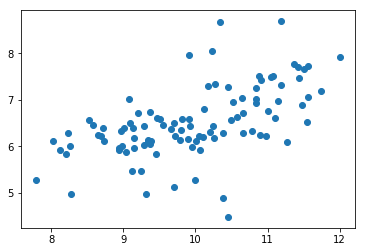

In [18]:
plt.scatter(dgw_norm_norm[:,1], dg_M_norm[:,1])

#plt.scatter()

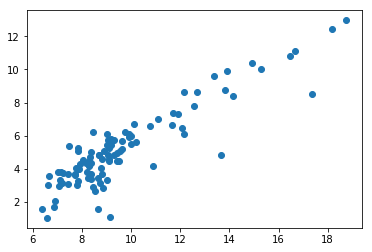

In [20]:
plt.scatter(dgw_norm_norm[:,3], dg_M_norm[:,3])

#plt.scatter()

In [31]:
g_324 =  experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[3])

Text(0.5, 0, '$\\phi_3$')

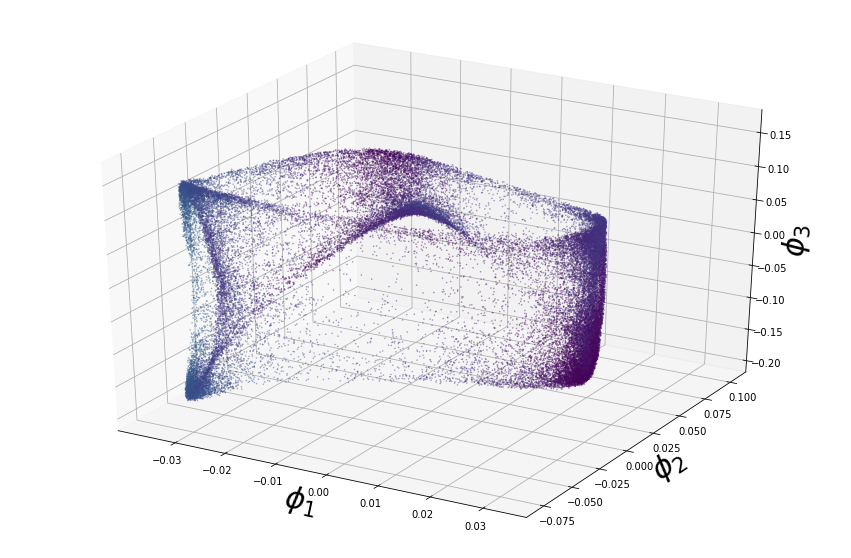

In [32]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')
#
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_324, alpha=alpha, marker='.',vmin = 0, vmax = np.pi)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)


Text(0.5, 0, '$\\phi_3$')

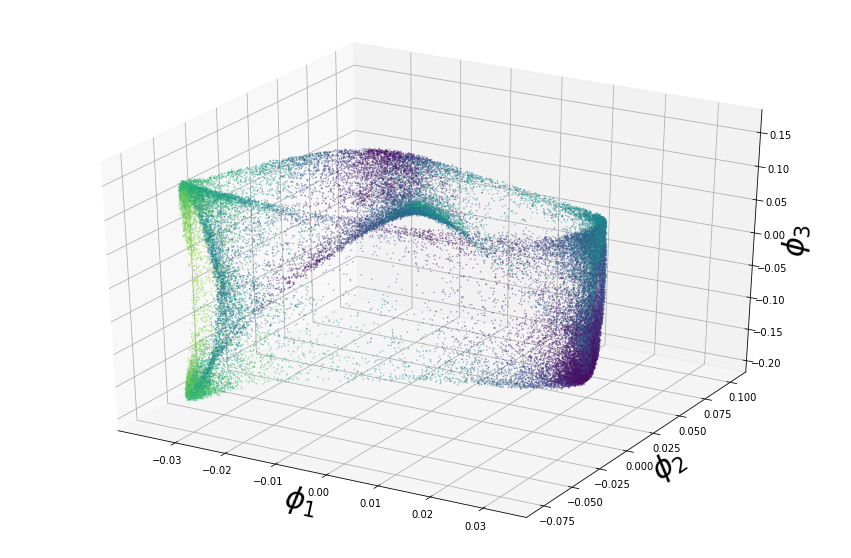

In [39]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_324, alpha=alpha, marker='.',vmin = 0, vmax = g_324.max())
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

In [23]:
ptproj = np.linalg.norm(np.einsum('n m  d, n p d -> n p m ' ,replicates[r].df_M , replicates[r].dg_M[:,:,:]), axis = tuple([2]))
ppts = ptproj#[:,trueandsel]

Text(0.5, 1.0, '$g_3$')

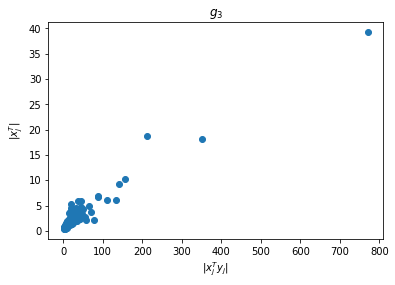

In [24]:
plt.scatter(ppts[:,2], dg_M_norm[:,2])
plt.ylabel(r'$\|x_j^T\|$')
plt.xlabel(r'$\|x_j^T y_j\|$')
plt.title(r'$g_3$')

Text(0.5, 1.0, '$g_3$')

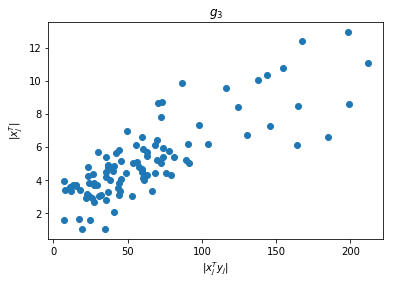

In [25]:
plt.scatter(ppts[:,3], dg_M_norm[:,3])
plt.ylabel(r'$\|x_j^T\|$')
plt.xlabel(r'$\|x_j^T y_j\|$')
plt.title(r'$g_3$')

In [35]:
g_324.max()

1.1381916545924227

In [38]:
np.pi/3

1.0471975511965976

In [42]:
2 / np.sqrt(3) 

1.1547005383792517

In [43]:
experiment.atoms4

array([[6, 1, 0, 4],
       [8, 2, 0, 4],
       [7, 2, 8, 1],
       [0, 5, 7, 8]])

In [44]:
g_423 =  experiment.get_g_full_sub(experiment.M.data, experiment.atoms4[2])

Text(0.5, 0, '$\\phi_3$')

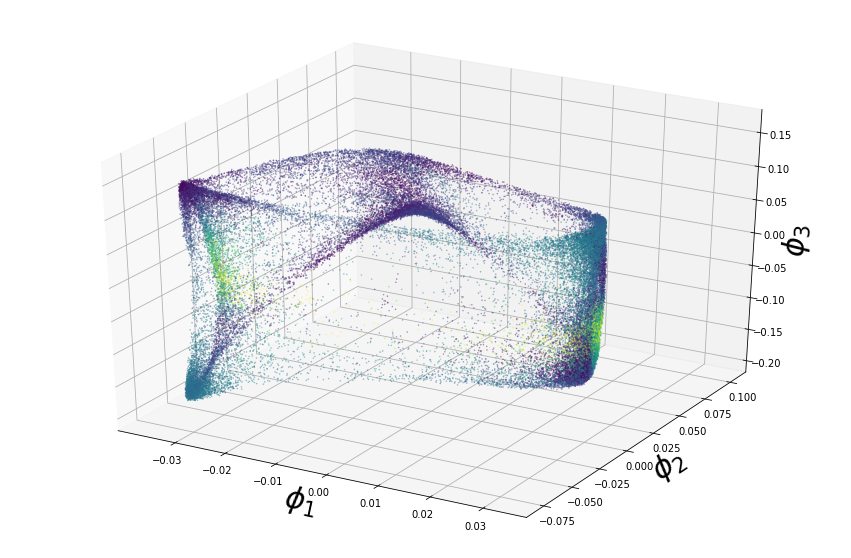

In [49]:
%matplotlib inline

data = experiment.N.data
axes = [0,1,2]
s = 1
alpha = .5
selected_points = list(range(50000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1, projection='3d')

#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z,  s=s,c = g_423, alpha=alpha, marker='.',vmin = 0, vmax = g_423.max()/3)
ax.set_xlabel(r'$\phi_1$', fontsize = 30)
ax.set_ylabel(r'$\phi_2$', fontsize = 30)
ax.set_zlabel(r'$\phi_3$', fontsize = 30)

In [48]:
g_423.max()

3.119012761897091

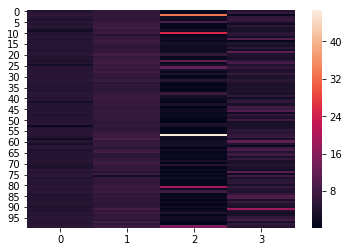

In [57]:
sns.heatmap(dg_M_norm)

In [65]:
dg_M_norm = np.linalg.norm(replicates[r].dg_M, axis =2)

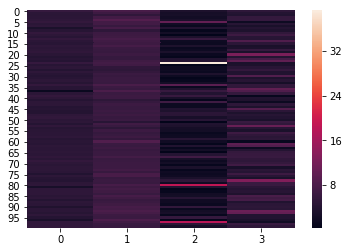

In [66]:
sns.heatmap(dg_M_norm)